# CLIP

## Instalar de librerías

In [1]:
%%capture
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

## Importar de librerías

In [2]:
import numpy as np
import torch
import clip
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

## Cargar el modelo

In [3]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/32", device=DEVICE)
model.cuda().eval();

## Preprocesamiento


### Imágenes

In [14]:
print("Resolución de las imágenes:", model.visual.input_resolution)

Resolución de las imágenes: 224


In [15]:
preprocess_clip

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7cc82f8d9bd0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

### Textos

In [16]:
print("Longitud del contexto:", model.context_length)

Longitud del contexto: 77


In [17]:
clip.tokenize("Hola mundo!")

tensor([[49406, 28724, 20990,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## Clasificador zero-shot

In [9]:
def preprocess_texts(dataset):
  text_descriptions = [f"This is a photo of a {label}" for label in dataset.classes]
  text_tokens = clip.tokenize(text_descriptions).to(DEVICE)
  return text_tokens

In [10]:
def preprocess_images(dataset, indexes):
  images = []
  labels = []
  original_images = []

  for idx in indexes:
    image, label = dataset[idx]
    label_name = dataset.classes[label]
    original_images.append((image, label_name))

    # Preprocesar la imagen para CLIP
    image_input = preprocess_clip(image).unsqueeze(0).to(DEVICE)
    images.append(image_input)
    labels.append(label)

  return (images, labels, original_images)

In [33]:
def show_example(dataset, index):
  image, label = dataset[index]
  plt.imshow(image)
  plt.title(f"Etiqueta: {dataset.classes[label]}\n Resolución: {image.size}")
  plt.axis('off')
  plt.show()

In [64]:
def show_predictions(dataset, original_images, predictions):
  # Mostrar las imágenes con sus predicciones
  plt.figure(figsize=(15, 5))
  for i in range(len(original_images)):
    image, label_name = original_images[i]
    predicted_class = dataset.classes[predictions[i].argmax()]

    # Mostrar la imagen
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Etiqueta real: {label_name}\nPredicción: {predicted_class}")
    plt.axis('off')
  plt.show()

### CIFAR100

In [18]:
from torchvision.datasets import CIFAR100

In [19]:
# Cargar el conjunto de datos CIFAR-100
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=None, download=True)

100%|██████████| 169001437/169001437 [00:02<00:00, 75006931.28it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


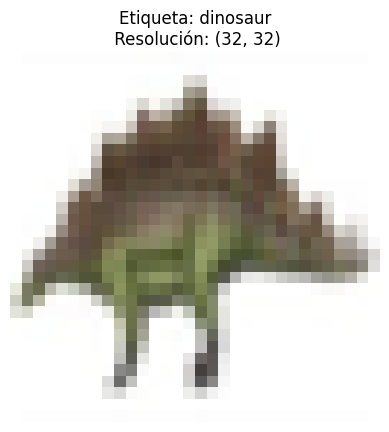

In [34]:
show_example(cifar100, 1)

In [22]:
# Preparar las descripciones de texto y tokenizarlas
text_tokens = preprocess_texts(cifar100)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

print("Longitud del contexto:", text_tokens[0].shape)
print("Vectores de textos:", text_features[:3])
print("Tamaño del espacio vectorial para el texto:", text_features[0].shape)

Longitud del contexto: torch.Size([77])
Vectores de textos: tensor([[-0.0048,  0.0590, -0.0039,  ..., -0.0234, -0.0152, -0.0048],
        [-0.0091, -0.0048,  0.0157,  ...,  0.0345,  0.0006,  0.0177],
        [ 0.0054,  0.0194, -0.0327,  ..., -0.0533, -0.0014, -0.0191]],
       device='cuda:0')
Tamaño del espacio vectorial para el texto: torch.Size([512])


In [23]:
# Seleccionar 3 índices aleatorios
indexes = random.sample(range(len(cifar100)), 3)

images, labels, original_images = preprocess_images(cifar100, indexes)

# Concatenar las imágenes en un solo tensor
image_inputs = torch.cat(images, dim=0)

with torch.no_grad():
  image_features = model.encode_image(image_inputs).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)

print("Resolución de las imágenes:", image_inputs[0].shape)
print("Tamaño del espacio vectorial para la imagen:", image_features[0].shape)

Resolución de las imágenes: torch.Size([3, 224, 224])
Tamaño del espacio vectorial para la imagen: torch.Size([512])


In [66]:
with torch.no_grad():
    # Calcular similitudes manualmente
    similarities = image_features @ text_features.T
    predictions = similarities.softmax(dim=-1).cpu().numpy()

#print(probs.shape)
#probs[0].sum()

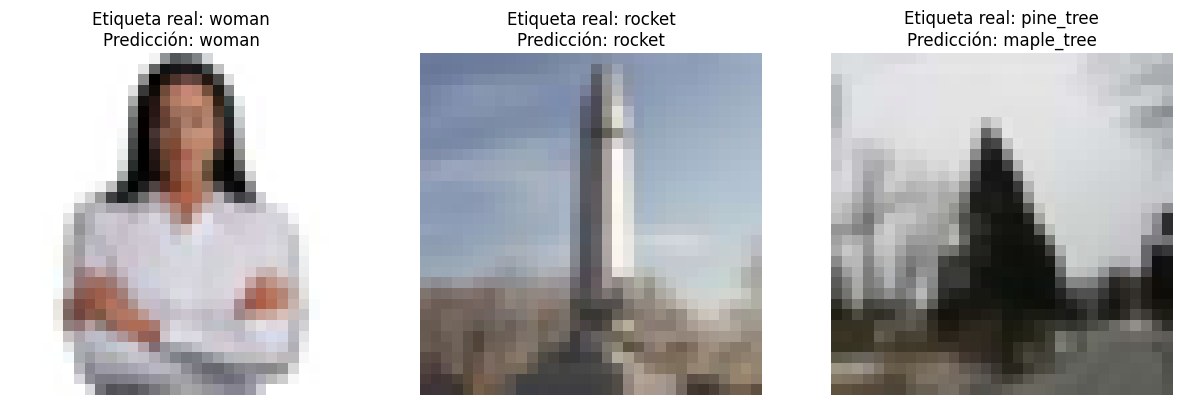

In [67]:
show_predictions(cifar100, original_images, predictions)

### STL10

In [68]:
from torchvision.datasets import STL10

In [69]:
# Cargar el conjunto de datos STL10 sin transformaciones
stl10 = STL10(os.path.expanduser("~/.cache"), split='test', transform=None, download=True)

100%|██████████| 2640397119/2640397119 [03:03<00:00, 14424489.30it/s]


Extracting /root/.cache/stl10_binary.tar.gz to /root/.cache


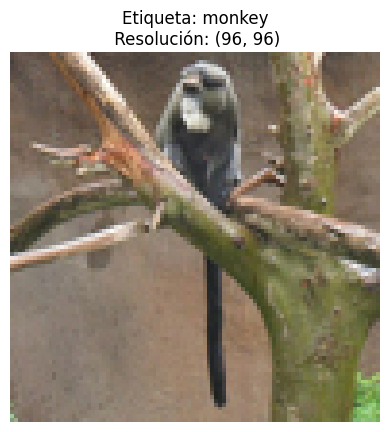

In [70]:
show_example(stl10, 1)

In [71]:
text_tokens = preprocess_texts(stl10)

In [73]:
# Seleccionar 3 índices aleatorios
indexes = random.sample(range(len(stl10)), 3)

images, labels, original_images = preprocess_images(stl10, indexes)

# Concatenar las imágenes en un solo tensor
image_inputs = torch.cat(images, dim=0)

In [74]:
with torch.no_grad():
    # Calcular logits y obtener probabilidades
    logits_per_image, _ = model(image_inputs, text_tokens)
    predictions = logits_per_image.softmax(dim=-1).cpu().numpy()

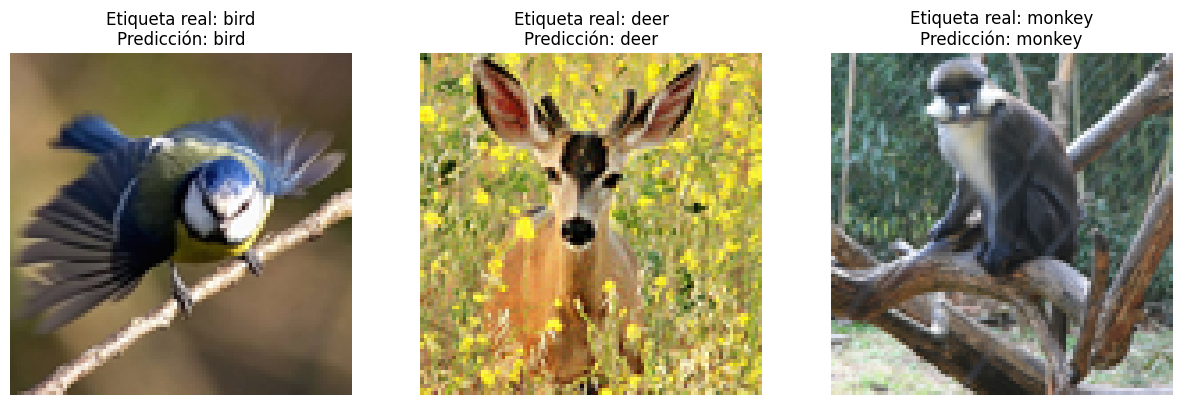

In [75]:
show_predictions(stl10, original_images, predictions)

## Buscar objetos



In [86]:
!wget https://github.com/theviderlab/computer_vision/raw/main/notebooks/clip/hidden-objects.jpg

--2024-09-18 15:47:45--  https://github.com/theviderlab/computer_vision/raw/main/notebooks/clip/hidden-objects.jpg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/theviderlab/computer_vision/main/notebooks/clip/hidden-objects.jpg [following]
--2024-09-18 15:47:45--  https://raw.githubusercontent.com/theviderlab/computer_vision/main/notebooks/clip/hidden-objects.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502528 (491K) [image/jpeg]
Saving to: ‘hidden-objects.jpg’

hidden-objects.jpg  100%[===================>] 490.75K  --.-KB/s    in 0.05s   

2024-09-18 15:47:45 (10.5 MB/s) - ‘hidden-obj

In [87]:
image_path = os.path.join('/content', 'hidden-objects.jpg')
image = Image.open(image_path)

width, height = image.size
print(image.size)

(1920, 1080)


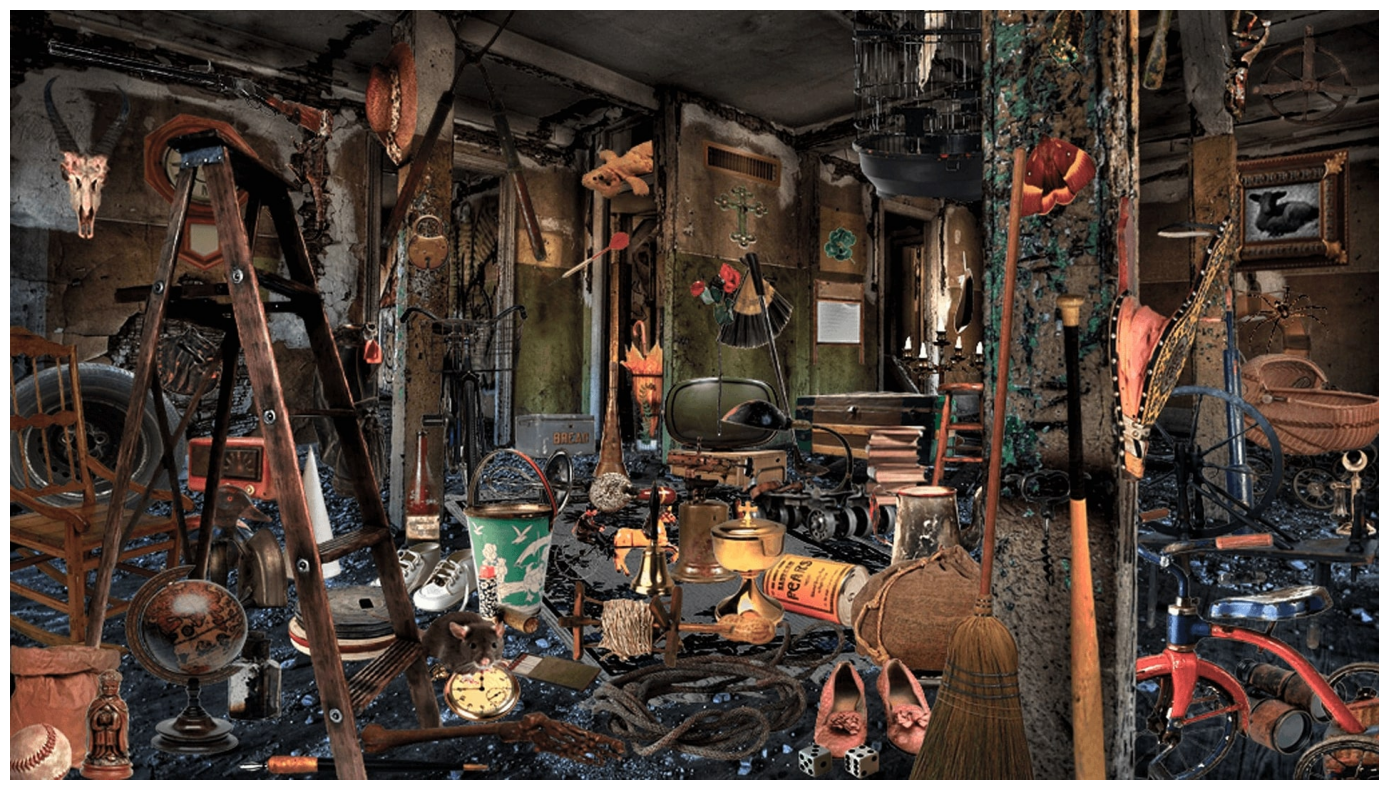

In [93]:
plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [100]:
def get_region(x, y, patch_dim, window, image):
  left = x * patch_dim
  upper = y * patch_dim
  right = left + window * patch_dim
  lower = upper + window * patch_dim

  # Extraer la región de la imagen
  region = image.crop((left, upper, right, lower))

  return region

In [105]:
# Definir el tamaño de los parches
patch_dim = 64

# Calcular el número de parches en cada dimensión
num_patches_x = width // patch_dim
num_patches_y = height // patch_dim

# Definir la ventana
window = 3

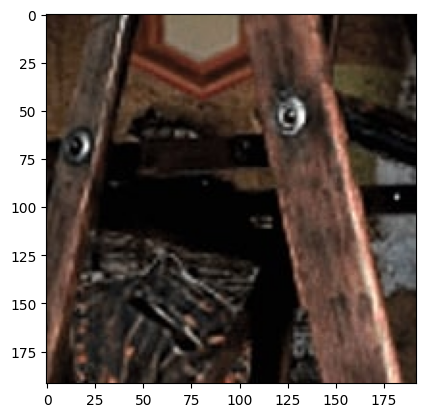

In [106]:
region = get_region(3, 5, patch_dim, window, image)
plt.imshow(region)
plt.show()

In [107]:
# Preparar el texto (en inglés para mejores resultados)
text_prompt = "image of a spider"
text_tokens = clip.tokenize([text_prompt]).to(DEVICE)

In [108]:
# Matriz para almacenar las probabilidades
pred_matrix = np.zeros((num_patches_x - window + 1, num_patches_y - window + 1))
pred_matrix.shape

(28, 14)

In [109]:
# Recorrer la imagen con una ventana deslizante
for x in range(pred_matrix.shape[0]):
    for y in range(pred_matrix.shape[1]):

        # Extraer la región de la imagen
        region = get_region(x, y, patch_dim, window, image)

        # Preprocesar la región para CLIP
        image_input = preprocess_clip(region).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            # Calcular logits y obtener la similitud directamente
            logits_per_image, _ = model(image_input, text_tokens)
            similarity = logits_per_image.squeeze().cpu().item()

        # Almacenar la similitud en la matriz
        pred_matrix[x, y] = similarity

In [170]:
# Normalizar el mapa de probabilidades entre 0 y 1
prediction = (pred_matrix - pred_matrix.min()) / (pred_matrix.max() - pred_matrix.min())
prediction[prediction < 0.8] = 0.1

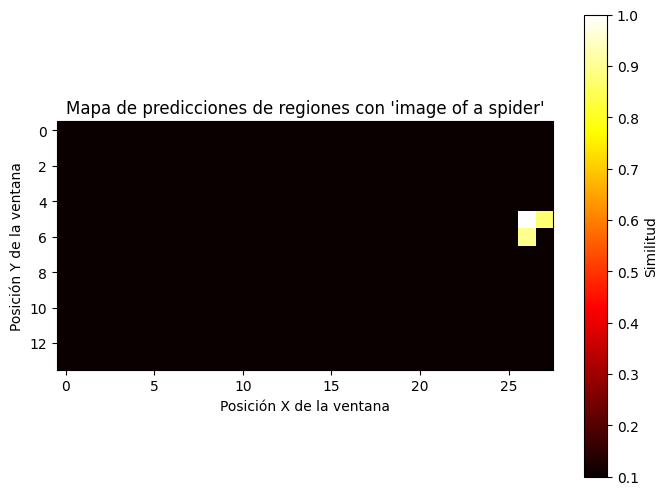

In [171]:
# Mostrar la matriz de probabilidades como una imagen
plt.figure(figsize=(8, 6))
plt.imshow(prediction.T, cmap='hot', interpolation='nearest')
plt.colorbar(label="Similitud")
plt.title(f"Mapa de predicciones de regiones con '{text_prompt}'")
plt.xlabel('Posición X de la ventana')
plt.ylabel('Posición Y de la ventana')
plt.show()

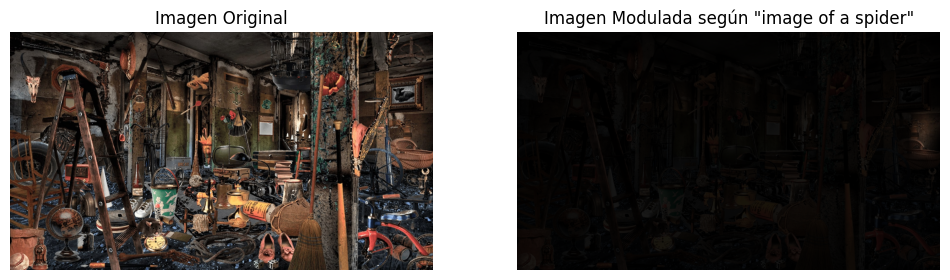

In [173]:
# Redimensionar el mapa de probabilidades al tamaño de la imagen
from scipy.ndimage import zoom

# Calcular el factor de ampliación
zoom_factor_x = width / prediction.shape[0]
zoom_factor_y = height / prediction.shape[1]

# Ampliar el mapa de probabilidades
prediction_map = zoom(prediction, (zoom_factor_x, zoom_factor_y), order=1)
prediction_map = prediction_map[:width, :height]
prediction_map = np.stack([prediction_map.T]*3, axis=-1)

# Modificar la intensidad de la imagen original
image_modulated = np.array(image)
image_modulated = image_modulated.astype(np.float32) * prediction_map
image_modulated = np.clip(image_modulated, 0, 255).astype(np.uint8)
image_modulated = Image.fromarray(image_modulated)

# Mostrar la imagen original y la imagen modulada
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_modulated)
plt.title(f'Imagen Modulada según "{text_prompt}"')
plt.axis('off')

plt.show()

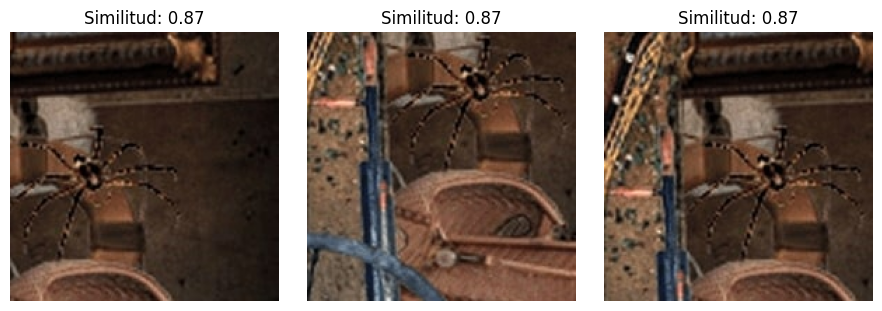

In [191]:
num_top_patches = 3

aplanada = prediction.flatten()
indices_ordenados = np.argsort(aplanada)
indices_mayores = indices_ordenados[-num_top_patches:]
coordinates = np.unravel_index(indices_mayores, prediction.shape)

# Extraer y mostrar los parches correspondientes
plt.figure(figsize=(15, 6))
for idx in range(num_top_patches):
    # Extraer la región de la imagen
    x = coordinates[0][idx]
    y = coordinates[1][idx]
    region = get_region(x, y, patch_dim, window, image)

    # Mostrar el parche
    plt.subplot(2, 5, idx + 1)
    plt.imshow(region)
    plt.title(f"Similitud: {prediction[i, j]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Fine-tuning

### Instalar Kaggle

In [192]:
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.6.17-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


### Descargar dataset

In [193]:
%%capture

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar el dataset
!kaggle datasets download -d kursatkomurcu/satellite-image-caption-change-detection
!mkdir my_dataset
!unzip satellite-image-caption-change-detection.zip -d my_dataset

In [ ]:
# from google.colab import files
import json
from tqdm import tqdm

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms

# from transformers import CLIPProcessor, CLIPModel

In [ ]:
json_path = '/content/my_dataset/train_data.json'
test_json_path = '/content/my_dataset/test_data.json'
image_base_path = '/content/my_dataset/'

In [ ]:
model.cuda().train();

In [ ]:
# Load the CLIP model and processor
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# Load pre-trained CLIP model
# model, preprocess = clip.load("ViT-B/32", device=DEVICE, jit=False)

In [ ]:
# Preprocessing pipeline (similar to CLIP's preprocessing)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to 224x224 (standard for ViT models)
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
# ])

In [ ]:
# Custom dataset class that handles images from JSON
class ImageTitleDataset(Dataset):
    def __init__(self, list_image_path, list_txt, transform=None):
        self.image_paths = list_image_path
        self.captions = list_txt
        self.transform = transform
        self.tokenized_captions = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Open image and ensure it's RGB
        if self.transform:
            image = self.transform(image)  # Apply transformations
        caption = self.tokenized_captions[idx]
        return image, caption

In [ ]:
# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

In [ ]:
# Parse the JSON data to extract image paths and titles
with open(json_path, 'r') as f:
    input_data = [json.loads(line) for line in f]

# Create full image paths using the base directory and the image paths in the JSON
list_image_path = [os.path.join(image_base_path, item['image_path']) for item in input_data]
list_txt = [item['product_title'][:40] for item in input_data]

# Create the custom dataset that pairs images with their titles
dataset = ImageTitleDataset(list_image_path, list_txt, transform=preprocess_clip)

# Use a DataLoader to load images in batches to save memory
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
if DEVICE == "cpu":
    model.float()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

# Specify the loss function
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [ ]:
# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images, texts = batch

        images = images.to(DEVICE)
        texts = texts.to(DEVICE)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images), dtype=torch.long, device=DEVICE)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2

        # Backward pass
        total_loss.backward()
        if DEVICE == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

Epoch 29/30, Loss: 2.4238:  92%|█████████▏| 2627/2849 [13:17<01:05,  3.39it/s]

In [ ]:
# Guardar los pesos del modelo después del entrenamiento
save_path = '/content/modelo_entrenado.pth'
torch.save(model.state_dict(), save_path)
print(f"Pesos del modelo guardados en {save_path}")